<a href="https://colab.research.google.com/github/boskidisanalysis/Stories-And-Images/blob/main/stories_and_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade diffusers transformers ftfy scipy #codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 34.3 MB/s 
     |████████████████████████████████| 4.9 MB 61.4 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 163 kB 70.4 MB/s 
     |████████████████████████████████| 6.6 MB 62.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [5]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
import matplotlib.pyplot as plt

In [6]:
filepath= '/content/drive/MyDrive/AI_photos/happy chihuahua et al/'
import os
if not os.path.exists(filepath):
   os.makedirs(filepath)

# Models

In [7]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

# Use the K-LMS scheduler here instead
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               #revision="fp16", 
                                               #torch_dtype=torch.float16,
                                               scheduler=scheduler,
                                               use_auth_token=True)
pipe = pipe.to(device)
pipe.enable_attention_slicing() #cost of 10% in speed but uses less gpu memory

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [8]:
story_models = ['bigscience/T0_3B','gpt2', 'gpt2-medium','distilgpt2','bigscience/bloom-560m']

In [9]:
from transformers import pipeline, set_seed
story_pipe = pipeline('text-generation', model=story_models[1])

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [10]:
prompt_models = ['succinctly/text2image-prompt-generator','Gustavosta/MagicPrompt-Stable-Diffusion','bartman081523/stable-diffusion-prompt-generator-gpt2']

In [11]:
from transformers import pipeline, set_seed
prompt_pipe = pipeline('text-generation', model=prompt_models[1])

Downloading:   0%|          | 0.00/912 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [12]:
from datetime import datetime

date = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

#Functions

In [13]:
def make_prompt(initial_prompt,max_length=60,number_of_images=2):
    
    prompt = prompt_pipe(initial_prompt,max_length=max_length, num_return_sequences=number_of_images)
    generated_prompt = [text['generated_text'] for text in prompt]
    return generated_prompt

In [14]:
def make_story(initial_prompt,max_length=60,number_of_stories=5,**kwargs):
    
    prompt = story_pipe(initial_prompt, max_length=max_length, num_return_sequences=number_of_stories)
    generated_prompt = [text['generated_text'] for text in prompt]
    return generated_prompt

In [15]:
def save_images(images, filepath,prompt):
    for num, image in enumerate(images):
        topnames= prompt[num].split()[:10]
        savenames = ' '.join(topnames)
        date = datetime.now().strftime(" %Y_%m_%d-%I_%M_%S")
        image.save(f'{filepath + savenames +date} {num}.png')

def metadata_plot(images, filepath, prompt,initial_prompt):
    #with plt.xkcd():
    fig, axs = plt.subplots(len(images),figsize=(12, 12))
    axs = axs.flatten()
    fig.patch.set_facecolor('white')
    for img, ax, txt in zip(images, axs,prompt):
        ax.imshow(img,aspect='equal')
        ax.set_axis_off()
        toptext= txt.split()[:8]
        savename = ' '.join(toptext)
        ax.set_title(txt,wrap=True)
  #         fig.suptitle(f'Total emissions from the generated images: {round(co2_emissions*1000,3)} g of CO2',
  #                      weight='bold')
      #plt.show();
    #plt.tight_layout()
    fig.suptitle(initial_prompt)
    fig
    date = datetime.now().strftime(" %Y_%m_%d-%I_%M_%S")
    topnames= initial_prompt.split()[:10]
    savenames = ' '.join(topnames)
    plt.savefig(f'{filepath + savenames+ date} metadata.png')

#from codecarbon import track_emissions
#  decorator(@) track_emissions
def make_and_save_images(prompt,initial_prompt,filepath,guidance_scale=7.5,num_inference_steps=50,*args,**kwargs):
    '''
    **kwargs: 
              guidance_scale:
              num_inference_steps: 
    '''

#     from codecarbon import EmissionsTracker
#     tracker = EmissionsTracker()
#     tracker.start()
    with autocast('cuda'):
        images = pipe(prompt,guidance_scale=guidance_scale,num_inference_steps=num_inference_steps).images
#     co2_emissions = tracker.stop()
#     tracker.stop()
    metadata_plot(images,filepath,prompt,initial_prompt,)
    save_images(images,filepath,prompt)

In [16]:
def make_images(initial_prompt,filepath,random_prompts=True,num_images=4,*args,**kwargs):
  '''
  Create and Saves images to a filepath from an initial prompt.  

  initial_prompt: (str) your prompt to genarate images from
  filepath: (str) the filepath in which the images will be saved
  random_prompts: (bool) if True uses a model to enhance the prompt, 
                  if False uses only the prompt provided
  num_images: (int) The number of images to be created
  
  **kwargs: 
  max_length= int, default 50
  guidance_scale: default 7.5
  num_inference_steps: default 50
  
  '''
  if not random_prompts:
    prompts = [initial_prompt]*num_images
  else:
    prompts = make_prompt(initial_prompt ,number_of_images=num_images)
  make_and_save_images(prompts,initial_prompt,filepath,*args,**kwargs)

#Inference

In [17]:
initial_prompt = "a painting of a cute chihuahua with a cute hat" #@param {type:"string"}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/25 [00:00<?, ?it/s]

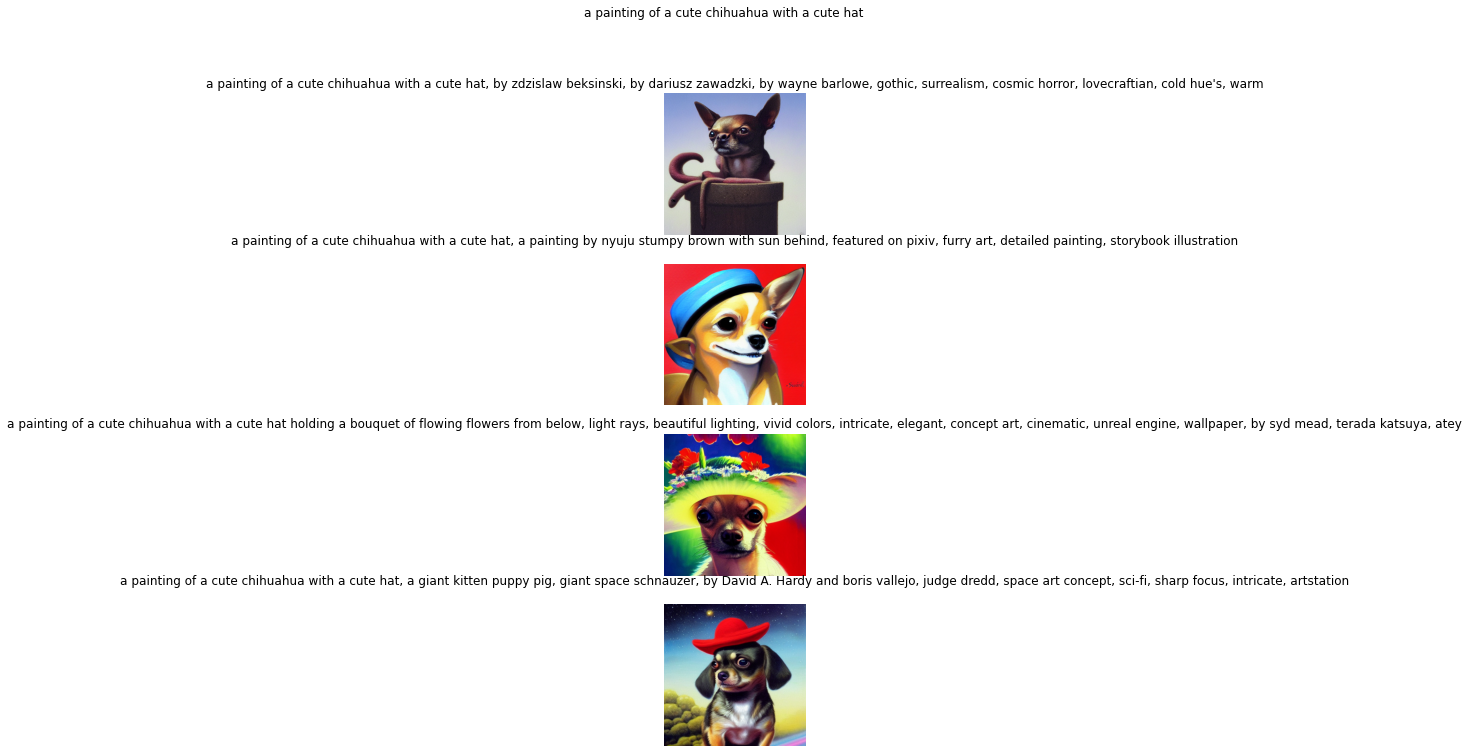

In [20]:
make_images(initial_prompt, filepath,random_prompts=True, max_length=50, num_inference_steps =25)

In [19]:
stories = make_story(initial_prompt,max_length=50)
stories

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['a painting of a cute chihuahua with a cute hat.\n\n\nMy love interest is a mousetrap!\n\n\nNow, the real fun comes from me drawing my mousetrap!\n\nFor now it is called',
 'a painting of a cute chihuahua with a cute hat. The word used for him? GAY. I am from this time period where a boy was supposed to be a boy who loves people and is the most pure and kind he can',
 'a painting of a cute chihuahua with a cute hat in order to sell their wares. The story continues at a far better rate once he learns the meaning of life.\n\nThe film comes in at just over half a budget,',
 'a painting of a cute chihuahua with a cute hat. Her face is pale, a little red, and white. The words and the words that she uses, her personality and how she speaks.\n\nWhat is with all the children',
 'a painting of a cute chihuahua with a cute hat is also something that has gone around to every kid in the world: it has never been shown to work on children because it is a non-sexual item such as a toy of a']